In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt



In [2]:
# Suppress TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

# Hyperparameters
BATCH_SIZE    = 64
INPUT_SIZE    = 224         # 224×224 for EfficientNetB0 :contentReference[oaicite:4]{index=4}
NUM_CLASSES   = 100
LR_HEAD       = 1e-3
LR_FINE       = 1e-5
EPOCHS_HEAD   = 25
EPOCHS_FINE   = 20
L2_LAMBDA     = 2e-4


In [3]:
# Load CIFAR-100
(x_train, y_train), (x_test, y_test) = datasets.cifar100.load_data()

# Preprocessing: resize only (no manual normalization)
def preprocess(image, label):
    image = tf.image.resize(image, [INPUT_SIZE, INPUT_SIZE])
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
                   .shuffle(50000) \
                   .batch(BATCH_SIZE)


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [4]:

# Data augmentation after resizing
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
                        .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
                        .batch(BATCH_SIZE) \
                        .prefetch(tf.data.AUTOTUNE)


In [5]:

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Build model with EfficientNetB0 backbone (includes Rescaling layer) :contentReference[oaicite:5]{index=5}
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(INPUT_SIZE, INPUT_SIZE, 3)
)
base_model.trainable = False  # Phase 1

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=LR_HEAD),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [7]:
# Phase 1: Train only the head
history_head = model.fit(
    train_ds,
    epochs=EPOCHS_HEAD,
    validation_data=test_ds,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 134s 119ms/step - accuracy: 0.3353 - loss: 3.2658 - val_accuracy: 0.6481 - val_loss: 1.5538 - learning_rate: 0.0010
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.5014 - loss: 2.2536 - val_accuracy: 0.6783 - val_loss: 1.5158 - learning_rate: 0.0010
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.5262 - loss: 2.1721 - val_accuracy: 0.6839 - val_loss: 1.5250 - learning_rate: 0.0010
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.5427 - loss: 2.1162 - val_accuracy: 0.6874 - val_loss: 1.5294 - learning_rate: 0.0010
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.5478 - loss: 2.1109 - val_accuracy: 0.6875 - val_loss: 1.5334 - learning_rate: 0.0010
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.5560 - loss: 2.0899 - val_accuracy: 0.6941 - val_loss: 1.5355 - learning_rate: 0.0010
Epoch 7/25
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5582 - 

In [8]:
# Phase 2: Unfreeze last 20 layers (except BatchNorm) for fine-tuning :contentReference[oaicite:6]{index=6}
for layer in base_model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(learning_rate=LR_FINE),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    epochs=EPOCHS_FINE,
    validation_data=test_ds,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 117s 112ms/step - accuracy: 0.6184 - loss: 1.6755 - val_accuracy: 0.7297 - val_loss: 1.2467 - learning_rate: 1.0000e-05
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.6334 - loss: 1.6096 - val_accuracy: 0.7357 - val_loss: 1.2251 - learning_rate: 1.0000e-05
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.6525 - loss: 1.5451 - val_accuracy: 0.7404 - val_loss: 1.2102 - learning_rate: 1.0000e-05
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.6577 - loss: 1.5245 - val_accuracy: 0.7439 - val_loss: 1.1965 - learning_rate: 1.0000e-05
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.6612 - loss: 1.4927 - val_accuracy: 0.7448 - val_loss: 1.1844 - learning_rate: 1.0000e-05
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.6645 - loss: 1.4859 - val_accuracy: 0.7479 - val_loss: 1.1747 - learning_rate: 1.0000e-05
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/s

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7660 - loss: 1.0941
Test Loss: 1.0908 | Test Accuracy: 76.63%


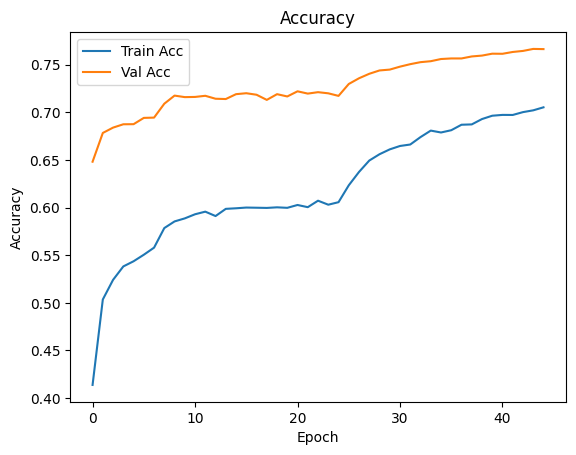

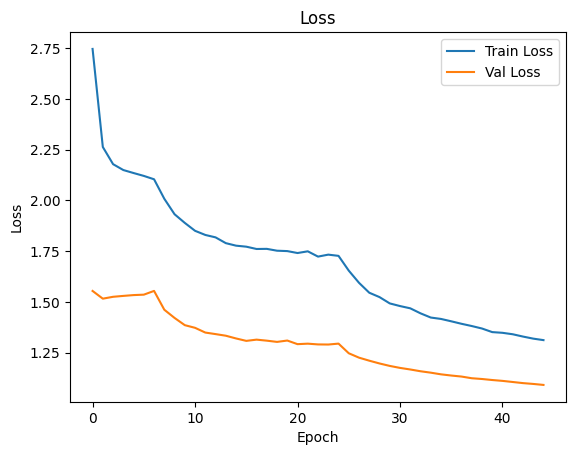

In [9]:

# Evaluate final performance
loss, accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {loss:.4f} | Test Accuracy: {accuracy*100:.2f}%")

# Plot training history
plt.figure()
plt.plot(history_head.history['accuracy']  + history_fine.history['accuracy'],  label='Train Acc')
plt.plot(history_head.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy'); plt.show()

plt.figure()
plt.plot(history_head.history['loss']      + history_fine.history['loss'],      label='Train Loss')
plt.plot(history_head.history['val_loss']  + history_fine.history['val_loss'],  label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss'); plt.show()


In [12]:
!pip install scikit-learn seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


Generating predictions for test set...
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.8868    0.9400    0.9126       100
           1     0.7946    0.8900    0.8396       100
           2     0.6970    0.6900    0.6935       100
           3     0.7324    0.5200    0.6082       100
           4     0.4571    0.6400    0.5333       100
           5     0.6891    0.8200    0.7489       100
           6     0.8614    0.8700    0.8657       100
           7     0.8929    0.7500    0.8152       100
           8     0.9247    0.8600    0.8912       100
           9     0.9271    0.8900    0.9082       100
          10     0.7263    0.6900    0.7077       100
          11     0.6024    0.5000    0.5464       100
          12     0.9091    0.8000    0.8511       100
          13     0.8714    0.6100    0.7176       100
          14     0.8750    0.7700    0.8191       100
          15     0.8058    0.

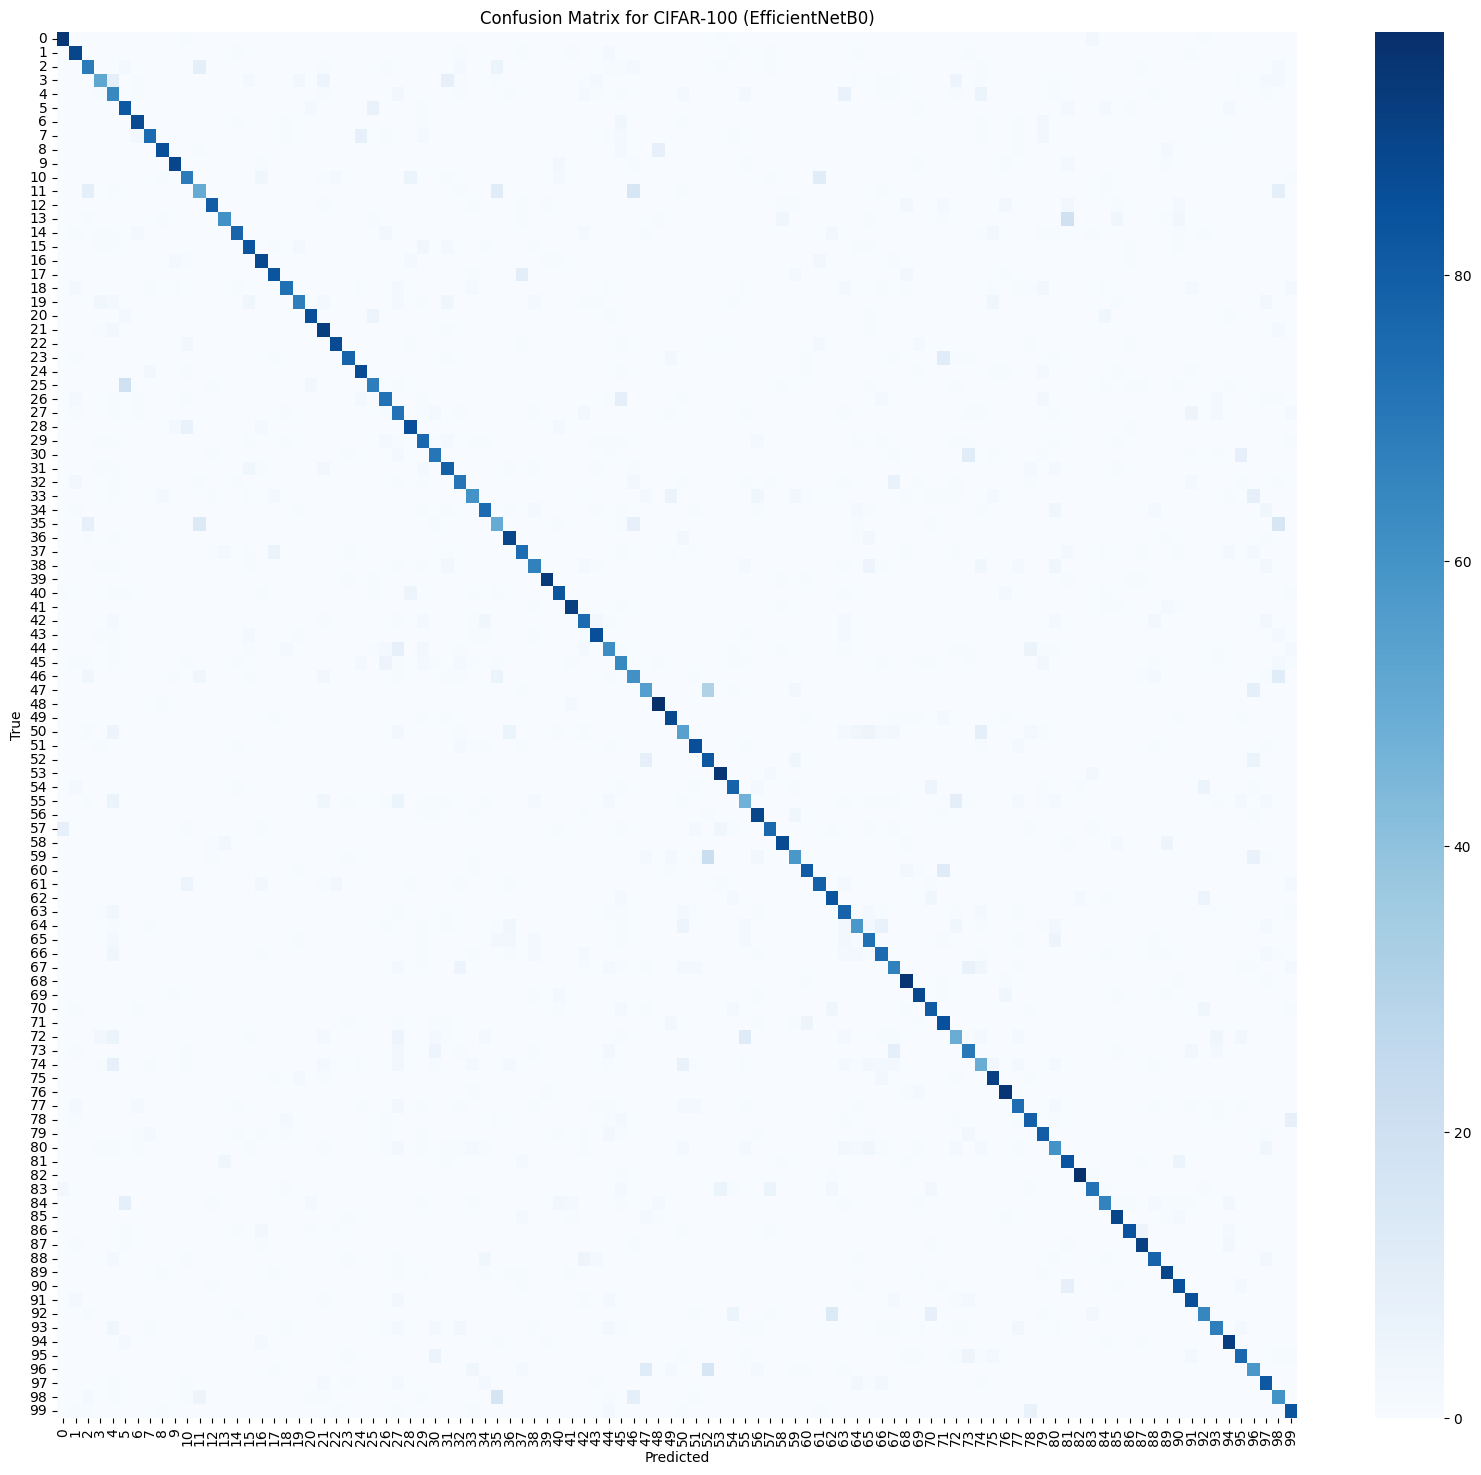

In [13]:
# Generate predictions for classification report and confusion matrix
print("\nGenerating predictions for test set...")
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = y_test.flatten()  # Flatten to match y_pred shape

# Load CIFAR-100 class names (fine labels)
# CIFAR-100 fine label names are available online or can be hardcoded
# For simplicity, we’ll use indices (0–99) as labels; replace with actual names if needed
class_names = [str(i) for i in range(100)]  # Placeholder: replace with actual CIFAR-100 fine labels if available

# Optional: Load actual CIFAR-100 fine label names (manually defined or from external source)
# Example (subset for brevity):
cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    # ... (add all 100 labels)
    'woman', 'worm'
]  # Full list should have 100 entries

# Use actual class names if available, otherwise fallback to indices
class_names = cifar100_fine_labels if len(cifar100_fine_labels) == 100 else class_names

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Compute and visualize confusion matrix
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(20, 18))  # Large size due to 100 classes
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIFAR-100 (EfficientNetB0)')
plt.show()